In [1]:
pip install pyts

Note: you may need to restart the kernel to use updated packages.


In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import scipy
import re
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.preprocessing as preprocessing
from collections import Counter

from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import *

os.chdir(os.getcwd())

#ZeroPadding3D
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from pyts.image import RecurrencePlot
import shutil
shutil.rmtree('C:\\Users\\jagat\\Downloads\\weights', ignore_errors=True)
shutil.rmtree('C:\\Users\\jagat\\Downloads\\logs', ignore_errors=True)
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("============GPU================")
# 查看GPU信息
!/opt/bin/nvidia-smi
print("============CPU================")
# 查看cpu配置
!cat /proc/cpuinfo | grep model\ name
print("=============MEMORY===============")
# 查看内存容量
!cat /proc/meminfo | grep MemTotal

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6052324203606367584
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1878136483792383587
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
============GPU================
============CPU================


The system cannot find the path specified.


=============MEMORY===============


'cat' is not recognized as an internal or external command,
operable program or batch file.
'cat' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#top = "/content/drive/MyDrive/USC-HAD/" 
top = "C:\\Users\\jagat\\Desktop\\Masters\\Team Project/USC-HAD/USC-HAD/USC-HAD/" 

In [5]:
df_num = 0
for root, dirs, files in os.walk(top, topdown=True):
  for file in files:
    if '.mat' in file:
      df_num += 1
print(df_num)

840


In [6]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.8.0


'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [7]:
acz={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[]}
i=1
for root, dirs, files in os.walk(top, topdown=True):
  for file in files:
    if '.mat' in file:
        sensor_readings = []
        acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z = [],[],[],[],[],[]
        D = loadmat(os.path.join(root, file))
        if D.get("activity_number") is None:
            #activity_numbers = '404'
            p=1
        else:
            activity_numbers = D['activity_number'][0]
        acz[int(activity_numbers)].append(file)

In [8]:
acp={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[]}
for i in range(len(acz)):
    p=acz[i+1]
    for file in p:
        D = loadmat(os.path.join(root, file))
        acp[i+1].append(D['sensor_readings'])

In [9]:
#plt.plot(acp[1][0][:,0])
len(acp[1])
acp[4][0].shape

(6500, 6)

In [10]:
XPn=[]
for i in range(len(acp)):
    #XPn[i]=[]
    a=acp[i+1][0]
    for j in range(len(acp[i+1])-1):
        b=acp[i+1][j+1]
        vast= np.vstack((a,b))
        a = vast
    XPn.append(np.array(vast, dtype=object))
XPn=np.array(XPn, dtype=object)

In [11]:
for i in range(len(XPn)):print(XPn[i].shape)

(595000, 6)
(319000, 6)
(287200, 6)
(483000, 6)
(439600, 6)
(208600, 6)
(114800, 6)
(224000, 6)
(196000, 6)
(350000, 6)
(216216, 6)
(217322, 6)


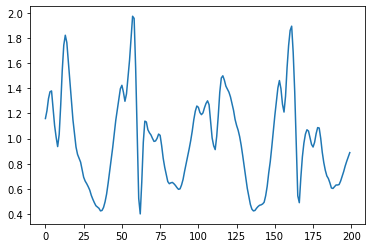

In [12]:
plt.plot(XPn[0][1800:2000,0])

In [13]:
# Apply 3rd order low pass Butterworth filter with a corner frequency of 30 Hz.
from scipy import signal
fs = 100  # sampling frequency
fc = 30  # cutoff frequency

w = fc / (fs / 3)  # Normalize the frequency
b, a = signal.butter(3, w, 'low')  # 3rd order low pass Butterworth filter

In [14]:
for i in range(len(XPn)):
    df_XPn = pd.DataFrame(XPn[i])
    df_med = df_XPn.rolling(window=10, center=True, min_periods=1).median()
    # print(df_med)
    df_med_but = signal.filtfilt(b, a, df_med, axis=0)
    # print(df_med_but.shape)
    df_med_but_norm = (df_med_but - df_med_but.mean()) / (df_med_but.std())
    # vast = df_med_but_norm.to_numpy()  

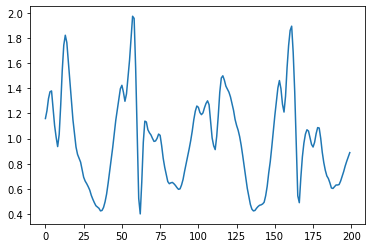

In [15]:
plt.plot(XPn[0][1800:2000,0])

In [16]:
class_labels = ['Walking Forward','Walking Left',' Walking Right',' Walking Upstairs',' Walking Downstairs'
                ,'Running Forward','Jumping Up',' Sitting',' Standing','Sleeping',
                'Elevator Up','Elevator Down']

In [17]:
def extract_sliding_windows(df_data, windows, steps, label):
    num_features = 6
    window_segments = []
    label_segments = []

    for i in range(0, (df_data.shape[0])-windows, steps):
        acc_x = df_data[:,0][i: i+windows]
        acc_y = df_data[:,1][i: i+windows]
        acc_z = df_data[:,2][i: i+windows]
        gyro_x = df_data[:,3][i: i+windows]
        gyro_y = df_data[:,4][i: i+windows]
        gyro_z = df_data[:,5][i: i+windows]
        window_segments.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
        label_segments.append(label)

    window_segments_reshape = np.asarray(window_segments, dtype= np.float32).transpose(0,2,1)#.reshape(-1, windows, num_features)
    label_segments = np.asarray(label_segments)

    return window_segments_reshape, label_segments

In [18]:
# 50% overlap
overlap_per=50
windows = 128 #  resample_len
steps = int(windows*(1-(overlap_per/100))) #64 
window_segments_reshape, label_segments = [], [] # window_segments_label_segments(df, windows, steps)
X_fin,y_fin= extract_sliding_windows(XPn[0], windows, steps, 1)
for i in range(len(XPn)-1):
    wind,lab= extract_sliding_windows(XPn[i+1], windows, steps, i+2)
    X_s= np.concatenate((X_fin, wind))
    y_s= np.concatenate((y_fin, lab))
    X_fin= X_s
    y_fin= y_s

In [19]:
Counter(y_fin)

Counter({1: 9295,
         2: 4983,
         3: 4486,
         4: 7545,
         5: 6867,
         6: 3258,
         7: 1792,
         8: 3498,
         9: 3061,
         10: 5467,
         11: 3377,
         12: 3394})

In [20]:
X_fin.shape

(57023, 128, 6)

In [21]:
print(len(X_fin))
print(len(X_fin[0]))
print(X_fin.shape)
print(X_fin[0].shape)
print(y_fin.shape)

57023
128
(57023, 128, 6)
(128, 6)
(57023,)


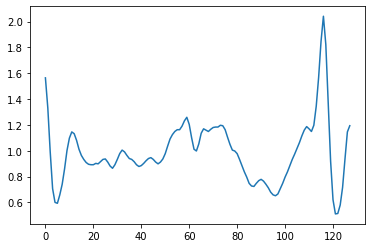

In [22]:
plt.plot(X_fin[0][:,0])

In [23]:
y_tr = to_categorical(y_fin)
final_Y = np.delete(y_tr,0,1)
final_Y.shape

(57023, 12)

X_fin[:,:,3:] = X_fin[:,:,3:]/ max(X_fin[:,:,3:].max(), abs(X_fin[:,:,3:].min()))
X_fin[:,:,:3] = X_fin[:,:,:3]/ max(X_fin[:,:,:3].max(), abs(X_fin[:,:,:3].min()))

In [24]:
np.random.seed(0)
rand_indices= np.random.permutation(X_fin.shape[0])
X_fin= X_fin[rand_indices]
final_Y= final_Y[rand_indices]

#80,20 split
split= int(0.8*final_Y.shape[0])
train_split= rand_indices[:split]
test_split= rand_indices[split:]

In [25]:
X_train= X_fin[train_split]
X_test= X_fin[test_split]
Y_train= final_Y[train_split]
Y_test= final_Y[test_split]

In [26]:
shuff= np.random.permutation(X_train.shape[0])
X_train=X_train[shuff]
Y_train=Y_train[shuff]

In [27]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((45618, 128, 6), (45618, 12), (11405, 128, 6), (11405, 12))

In [28]:
def calc_tot_acc(X):
    p,q,r=X.shape
    X_new=np.zeros(shape=(p,q,r+1))
    X_new[:,:,:-1]=X
    for i in range(X.shape[0]):
        X_new[i,:,6]= np.sqrt(X[i,:,0]**2 + X[i,:,1]**2 + X[i,:,2]**2)
    return X_new

X_train=calc_tot_acc(X_train)
X_test=calc_tot_acc(X_test)

In [29]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((45618, 128, 7), (45618, 12), (11405, 128, 7), (11405, 12))

In [30]:
def plot_graphs(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy") 
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.show()

    train_acc = history.history['loss']
    val_acc = history.history['val_loss']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.show()
    
    shutil.rmtree('C:\\Users\\jagat\\Downloads\\weights', ignore_errors=True)
    shutil.rmtree('C:\\Users\\jagat\\Downloads\\logs', ignore_errors=True)
def calc_scores(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    return len(train_acc),train_acc[-1]*100,val_acc[-1]*100

scores=np.zeros(shape=(8,3))

In [31]:
X_train_base= X_train.reshape(-1,32,28,1) #(-1,X_train.shape[1]*X_train.shape[2])
X_test_base= X_test.reshape(-1,32,28,1) #reshape(-1,X_test.shape[1]*X_test.shape[2])
x1,x2,x3, x4= X_train_base.shape
#X_train_base=X_train_base.reshape(x1,x2,x3,1)
#X_test_base=X_test_base.reshape(x1,x2,x3,1)
x1,x2,x3

(45618, 32, 28)

Model: "CNN_simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 24, 32)        832       
                                                                 
 dropout (Dropout)           (None, 28, 24, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 24, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 12, 32)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 16, 14, 32)       0         
 2D)                                                             
                                                        

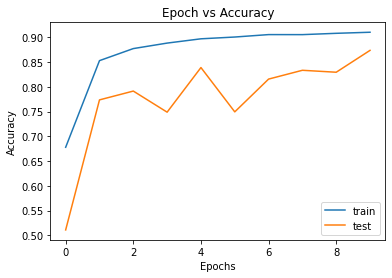

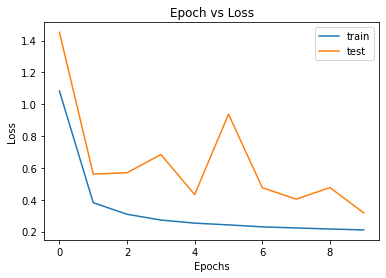

In [32]:

np.random.seed(0) 
model_simple_CNN = models.Sequential(name = 'CNN_simple') 

#model_simple_CNN.build(input_shape=(x2, x3, 1))
#model_simple_CNN.add(layers.ZeroPadding2D(padding=(2, 2)))
model_simple_CNN.add(Conv2D(32,(5, 5), activation='selu', input_shape=(x2, x3, 1)))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(MaxPooling2D((2,2)))
model_simple_CNN.add(layers.ZeroPadding2D(padding=(1, 1)))
model_simple_CNN.add(Conv2D(64,(3, 3), activation='selu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(layers.ZeroPadding2D(padding=(1, 1)))
model_simple_CNN.add(Conv2D(16,(3, 3), activation='selu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(BatchNormalization())
model_simple_CNN.add(layers.Flatten())
#model_simple_CNN.add(layers.Dense(3072, activation='relu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(layers.Dense(1536, activation='relu'))
model_simple_CNN.add(Dropout(0.6))
model_simple_CNN.add(layers.Dense(12, activation='softmax'))


print(model_simple_CNN.summary())
model_simple_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_simple_CNN.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_simple_CNN.fit(X_train_base, Y_train , epochs=10, batch_size=128,
                    validation_data=(X_test_base, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[0,:]=calc_scores(history)

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 64)                18688     
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 12)                1212      
                                                                 
Total params: 26,800
Trainable params: 26,600
Non-trainable params: 200
________________________________________________________

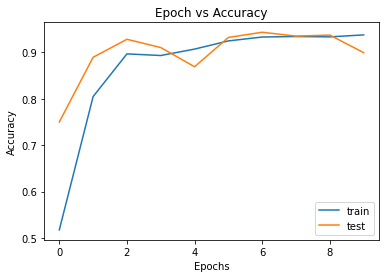

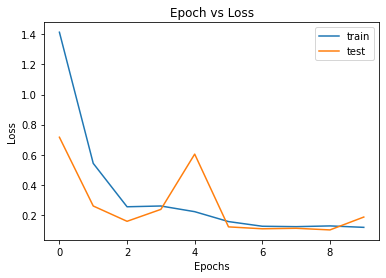

In [33]:
np.random.seed(0)
model_LSTM = Sequential(name = 'LSTM')
model_LSTM.add(CuDNNLSTM(64, input_shape=(None, X_train.shape[2]))) 
model_LSTM.add(Dense(100, activation='selu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dense(12, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
print(model_LSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_LSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_LSTM.fit(X_train, Y_train , epochs=10, batch_size=128, 
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[1,:]=calc_scores(history)

np.random.seed(0)
model_LSTM = Sequential(name = 'LSTM')
model_LSTM.add(LSTM(64, recurrent_dropout=0.5, input_shape=(None, X_train.shape[2]))) 
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dropout(0.5))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dense(12, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
print(model_LSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_LSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_LSTM.fit(X_train, Y_train , epochs=5, batch_size=1280, 
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[1,:]=calc_scores(history)

Model: "bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              140288    
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 100)               25700     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 12)                1212      
                                                                 
Total params: 167,600
Trainable params: 167,400


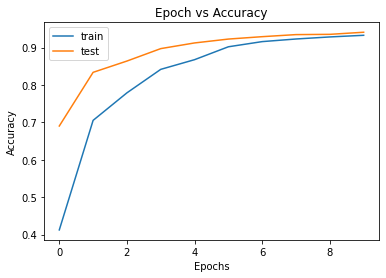

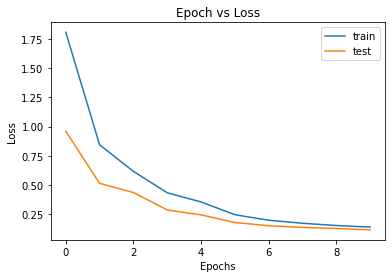

In [34]:
np.random.seed(0)
model_biLSTM = Sequential(name = 'bidirectional_LSTM')
model_biLSTM.add(Bidirectional(CuDNNLSTM(128), input_shape=(None, X_train.shape[2])))
model_biLSTM.add(Dense(100, activation='selu'))
model_biLSTM.add(Dropout(0.5))
model_biLSTM.add(BatchNormalization())
model_biLSTM.add(Dense(12, activation='softmax'))
model_biLSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
print(model_biLSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_biLSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_biLSTM.fit(X_train, Y_train , epochs=10, batch_size=1280,
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[2,:]=calc_scores(history)

In [35]:
X_fin2=np.concatenate((X_train,X_test))
for i in range(X_train.shape[2]):
    maxi=np.amax(X_fin2[:,:,i])
    mini=np.amin(X_fin2[:,:,i])
    
    X_train[:,:,i]= (X_train[:,:,i]-mini)/(maxi-mini)
    X_test[:,:,i]= (X_test[:,:,i]-mini)/(maxi-mini)

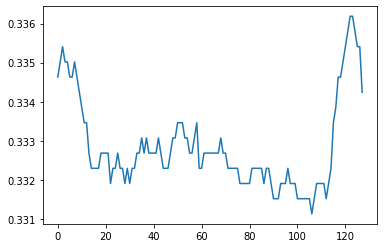

(1, 16, 16)


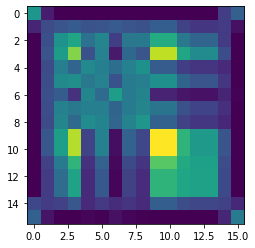

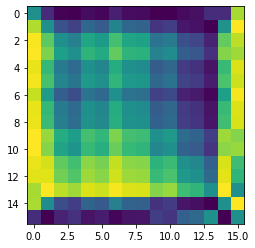

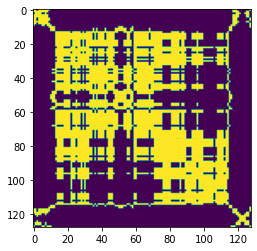

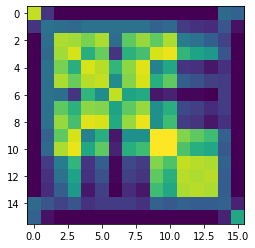

In [36]:
acv=X_train[0,:,0]
plt.plot(acv)
plt.show()
factor=8
k=int(len(acv)/factor)
transformer1 = MarkovTransitionField(image_size=1/factor,strategy='uniform', overlapping=True)#,strategy='uniform')
transformer2 = GramianAngularField(image_size=1/factor,method='difference',overlapping=True)
transformer3 = RecurrencePlot(threshold=0.0005)
transformer4 = RecurrencePlot()#threshold=10)
p=transformer1.transform(acv.reshape(1,-1))
q=transformer2.transform(acv.reshape(1,-1))
r=transformer3.transform(acv.reshape(1,-1))
print(p.shape)
plt.imshow(p.reshape(k,k));
plt.show()
plt.imshow(q.reshape(k,k));
plt.show()
plt.imshow(r.reshape(factor*k,factor*k));
plt.show()
avg_filt=layers.AveragePooling2D((factor, factor))
plt.imshow(avg_filt(r.reshape(1,len(acv),len(acv),1)).reshape(k,k));

In [37]:
import warnings

#suppress warnings like RunTime error
warnings.filterwarnings('ignore')

In [38]:
def new_X_MTF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2],1), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer1.transform(dt.reshape(1,-1))
            Xp[i,:,:,j,0]=img
    return Xp

X_MTF_train=new_X_MTF(X_train)
X_MTF_test=new_X_MTF(X_test)
x1,x2,x3,x4,x5= X_MTF_train.shape
#X_MTF_train=X_MTF_train.reshape(x1,x2,x3,x4,1)
#X_MTF_test=X_MTF_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

45618 16 16 7


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 12, 6, 10)     510       
                                                                 
 batch_normalization_5 (Batc  (None, 12, 12, 6, 10)    40        
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 12, 12, 6, 10)     0         
                                                                 
 zero_padding3d (ZeroPadding  (None, 16, 16, 8, 10)    0         
 3D)                                                             
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 14, 8, 20)     1820      
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 8, 20)     0

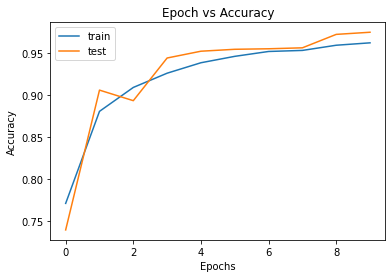

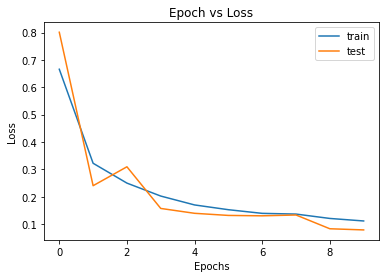

In [39]:
np.random.seed(0)

model_MTF = models.Sequential(name = 'Only MTF')
model_MTF.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))#, 1)))
model_MTF.add(BatchNormalization())
#model_MTF.add(layers.MaxPooling3D((2, 2, 1)))
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_MTF.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Conv3D(10, (4, 4, 1), activation='selu'))
model_MTF.add(layers.Flatten())
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(100, activation='relu'))
#model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(12, activation='softmax'))
print(model_MTF.summary())

model_MTF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_MTF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_MTF.fit(X_MTF_train, Y_train , epochs=10, 
                    batch_size=128, validation_data=(X_MTF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[3,:]=calc_scores(history)


In [40]:
def new_X_GAF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2],1), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer2.transform(dt.reshape(1,-1))
            Xp[i,:,:,j,0]=img
    return Xp

X_GAF_train=new_X_GAF(X_train)
X_GAF_test=new_X_GAF(X_test)
x1,x2,x3,x4,x5= X_GAF_train.shape
#X_GAF_train=X_GAF_train.reshape(x1,x2,x3,x4,1)
#X_GAF_test=X_GAF_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

45618 16 16 7


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 12, 6, 10)     510       
                                                                 
 batch_normalization_6 (Batc  (None, 12, 12, 6, 10)    40        
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 12, 12, 6, 10)     0         
                                                                 
 zero_padding3d_1 (ZeroPaddi  (None, 16, 16, 8, 10)    0         
 ng3D)                                                           
                                                                 
 conv3d_4 (Conv3D)           (None, 14, 14, 8, 20)     1820      
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 8, 20)    

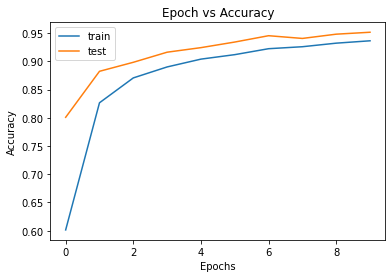

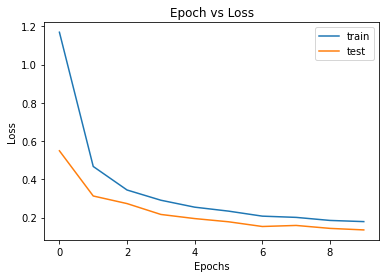

In [41]:
np.random.seed(0)
model_GAF = models.Sequential(name = 'Only GAF')
model_GAF.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_GAF.add(BatchNormalization())
#model_GAF.add(layers.MaxPooling3D((2, 2, 1)))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_GAF.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Conv3D(10, (4, 4, 1), activation='selu'))
model_GAF.add(layers.Flatten())
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(100, activation='relu'))
#model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(12, activation='softmax'))
print(model_GAF.summary())

model_GAF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_GAF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_GAF.fit(X_GAF_train, Y_train , epochs=10, 
                    batch_size=128, validation_data=(X_GAF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[4,:]=calc_scores(history)


In [42]:
def new_X_RP(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2],1), dtype=np.float32)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            #if j<7:
            img=transformer3.transform(dt.reshape(1,-1))
            #else:
            #    img=transformer4.transform(dt.reshape(1,-1))
            img=avg_filt(img.reshape(1,len(acv),len(acv),1)).reshape(k,k)
            Xp[i,:,:,j,0]=img
    return Xp

X_RP_train=new_X_RP(X_train)
X_RP_test=new_X_RP(X_test)
x1,x2,x3,x4,x5= X_RP_train.shape
#X_RP_train=X_RP_train.reshape(x1,x2,x3,x4,1)
#X_RP_test=X_RP_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

45618 16 16 7


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 12, 12, 6, 10)     510       
                                                                 
 batch_normalization_7 (Batc  (None, 12, 12, 6, 10)    40        
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 12, 12, 6, 10)     0         
                                                                 
 zero_padding3d_2 (ZeroPaddi  (None, 16, 16, 8, 10)    0         
 ng3D)                                                           
                                                                 
 conv3d_7 (Conv3D)           (None, 14, 14, 8, 20)     1820      
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 8, 20)    

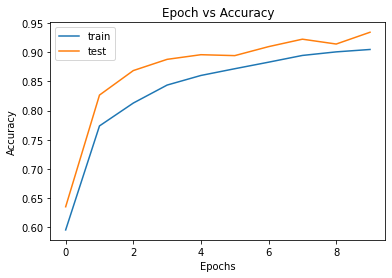

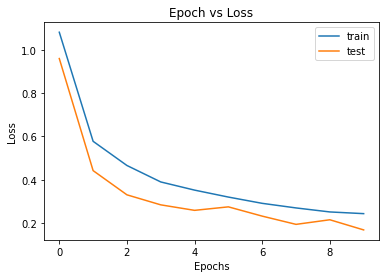

In [43]:
np.random.seed(0)

model_RP = models.Sequential(name ='Only RP')
model_RP.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_RP.add(BatchNormalization())
#model_RP.add(layers.MaxPooling3D((2, 2, 1)))
model_RP.add(Dropout(0.5))
model_RP.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_RP.add(layers.Conv3D(20, (3, 3, 1), activation='selu'))
model_RP.add(Dropout(0.5))
model_RP.add(layers.Conv3D(10, (4, 4, 1), activation='selu'))
model_RP.add(layers.Flatten())
model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(100, activation='relu'))
#model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(12, activation='softmax'))
print(model_RP.summary())


model_RP.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_RP.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_RP.fit(X_RP_train, Y_train , epochs=10, 
                    batch_size=128, validation_data=(X_RP_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[5,:]=calc_scores(history)


In [44]:
X_all_img_train=np.concatenate((X_GAF_train,X_MTF_train,X_RP_train),axis=3)
X_all_img_test=np.concatenate((X_GAF_test,X_MTF_test,X_RP_test),axis=3)

x1,x2,x3,x4,x5= X_all_img_train.shape
#X_all_img_train=X_all_img_train.reshape(x1,x2,x3,x4,1)
#X_all_img_test=X_all_img_test.reshape(x1,x2,x3,x4,1)
print(x1,x2,x3,x4)

45618 16 16 21


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 14, 14, 19, 10)    280       
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 19, 10)   40        
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 14, 9, 10)    0         
 )                                                               
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 9, 10)     0         
                                                                 
 zero_padding3d_3 (ZeroPaddi  (None, 18, 18, 11, 10)   0         
 ng3D)                                                           
                                                      

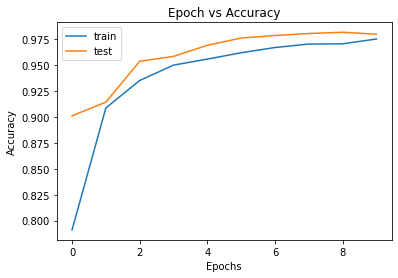

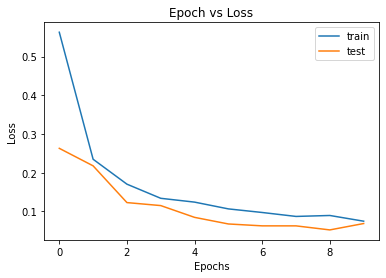

In [45]:
np.random.seed(0)
model = models.Sequential(name = 'Images combined')
model.add(layers.Conv3D(10, (3, 3, 3), activation='selu', input_shape=(x2,x3, x4, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling3D((1, 1, 2)))
model.add(Dropout(0.5))
model.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model.add(layers.Conv3D(20, (5, 5, 3), activation='selu'))
#model.add(Dropout(0.5))
model.add(layers.Conv3D(10, (4, 4, 2), activation='selu'))
model.add(layers.Flatten())
model.add(Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
#model.add(Dropout(0.5))
#model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
print(model.summary())


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)
shutil.rmtree('/content/weights', ignore_errors=True)
weights_dir = 'weights/' + model.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model.fit(X_all_img_train, Y_train , epochs=10, 
                    batch_size=128, validation_data=(X_all_img_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[6,:]=calc_scores(history)

357/357 [==============================] - 2s 4ms/step - loss: 0.0689 - accuracy: 0.9800


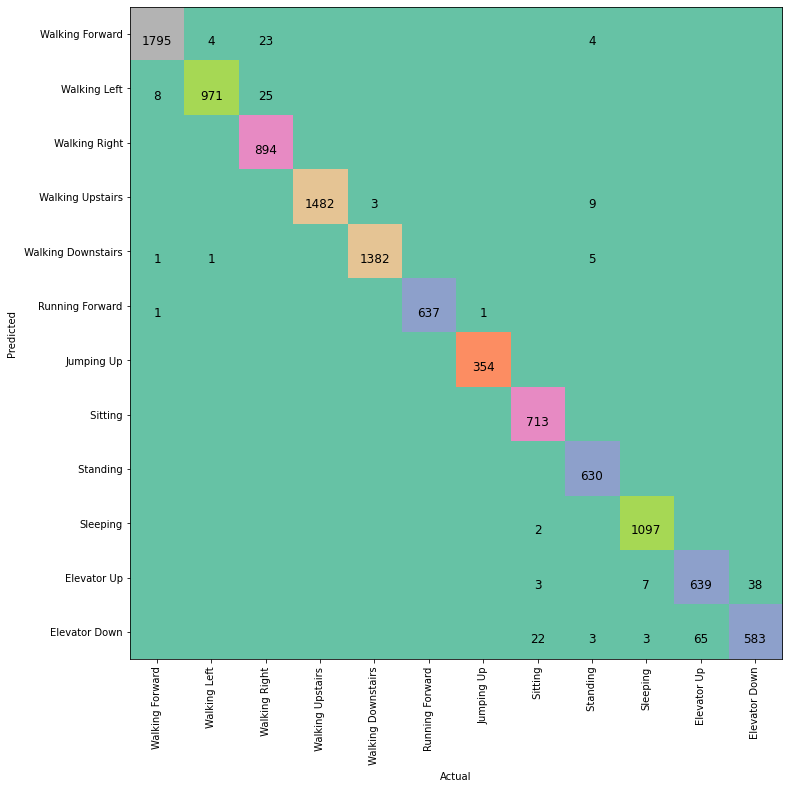

In [46]:
model.evaluate(X_all_img_test, Y_test)

pred = np.argmax(model.predict(X_all_img_test), axis = -1)
confusion = confusion_matrix(np.argmax(Y_test, axis = -1), pred)
NUM_LABELS = 12
f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(NUM_LABELS)))
axes.set_xticks(list(range(NUM_LABELS)))
plt.imshow(confusion, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

Model: "CNN_and_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 14, 14, 19, 10)    280       
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 19, 10)   40        
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 14, 14, 9, 10)    0         
 3D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 14, 14, 9, 10)     0         
                                                                 
 zero_padding3d_7 (ZeroPaddi  (None, 18, 18, 11, 10)   0         
 ng3D)                                                           
                                                      

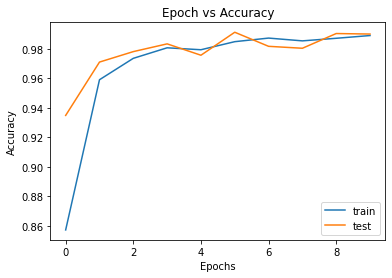

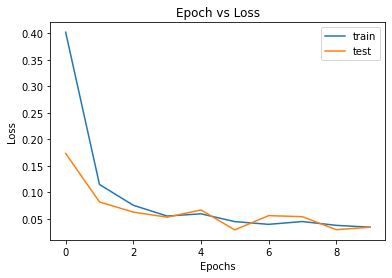

In [54]:
np.random.seed(0)
model_comb = models.Sequential(name = 'CNN_and_LSTM')
model_comb.add(layers.Conv3D(10, (3, 3, 3), activation='selu', input_shape=(x2,x3, x4, 1)))
model_comb.add(BatchNormalization())
model_comb.add(layers.MaxPooling3D((1, 1, 2)))
model_comb.add(Dropout(0.5))
model_comb.add(layers.ZeroPadding3D(padding=(2, 2, 1)))
model_comb.add(layers.Conv3D(20, (5, 5, 3), activation='selu'))
#model_comb.add(Dropout(0.5))
model_comb.add(layers.Conv3D(10, (4, 4, 2), activation='selu'))
model_comb.add(layers.TimeDistributed(Flatten()))
model_comb.add(Bidirectional(CuDNNLSTM(1024)))
model_comb.add(layers.Dense(100, activation='selu'))
#model_comb.add(Dropout(0.5))
#model_comb.add(layers.Dense(50, activation='relu'))
model_comb.add(layers.Dense(12, activation='softmax'))
print(model_comb.summary())


model_comb.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)
shutil.rmtree('/content/weights', ignore_errors=True)
weights_dir = 'weights/' + model_comb.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_comb.fit(X_all_img_train, Y_train , epochs=10, 
                    batch_size=128, validation_data=(X_all_img_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[7,:]=calc_scores(history)

357/357 [==============================] - 4s 12ms/step - loss: 0.0340 - accuracy: 0.9901


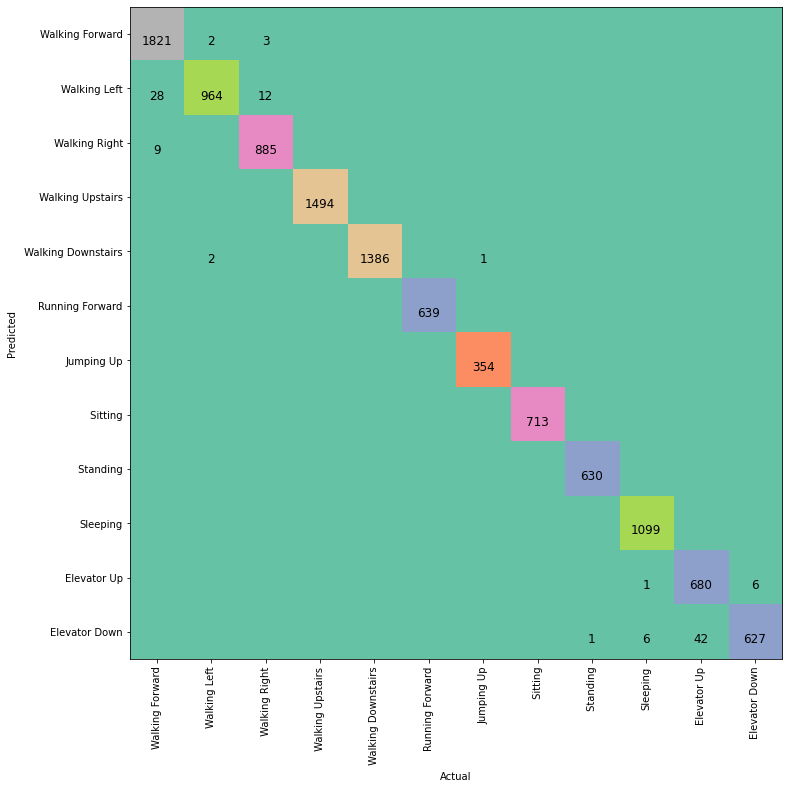

In [55]:
model_comb.evaluate(X_all_img_test, Y_test)

pred = np.argmax(model_comb.predict(X_all_img_test), axis = -1)
confusion = confusion_matrix(np.argmax(Y_test, axis = -1), pred)
NUM_LABELS = 12
f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(NUM_LABELS)))
axes.set_xticks(list(range(NUM_LABELS)))
plt.imshow(confusion, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

In [56]:
import pandas as pd
row_names=["CNN simple","LSTM simple","Bidirectional LSTM","MTF image CNN"
           ,"GAF image CNN","RP image CNN","MTF+GAF+RP image CNN","CNN+LSTM"]
column_names=["Epochs","Training Accuracy %","Test Accuracy %"]
Full_results= pd.DataFrame(scores, index=row_names, columns=column_names)
Full_results

,Epochs,Training Accuracy %,Test Accuracy %
CNN simple,10.0,91.043007,87.382728
LSTM simple,10.0,93.763429,89.943010
Bidirectional LSTM,10.0,93.274587,94.090313
MTF image CNN,10.0,96.216404,97.474790
GAF image CNN,10.0,93.636286,95.151252
RP image CNN,10.0,90.499365,93.459010
MTF+GAF+RP image CNN,10.0,97.540444,98.000878
CNN+LSTM,10.0,98.908323,99.009204
